In [51]:
import pickle
import os
from dotenv import load_dotenv
import wrds
import numpy as np
from numpy import log, log1p, exp, sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
PGUSER = os.getenv('PGUSER')
PGPASSWORD = os.getenv('PGPASSWORD')

ANN_FACTOR = 5

Getting data

In [52]:
conn = wrds.Connection()

Loading library list...
Done


In [53]:
# %%time
# conn.get_table(library='crsp', table='dsp500list', rows=10)
# conn.get_table(library='crsp', table='dsf', rows=10)

# getting DAILY returns for SP500 constituents + date range of their belonging to SP500
start_date = '01/01/2003'
df = conn.raw_sql(
        f"select a.*, b.date, b.ret \
        from crsp.dsp500list as a, \
        crsp.dsf as b \
        where a.permno = b.permno \
        and b.date >= a.start and b.date <= a.ending \
        and b.date >= '{start_date}'", date_cols=['start', 'ending', 'date']
    )

# getting additional company attributes / identifiers
temp = conn.raw_sql(
    """select namedt, nameendt, permno, shrcd, exchcd, ticker
        from crsp.dsenames""", date_cols=['namedt', 'nameendt']
    )

# merging, subsetting
df = df.merge(temp, how='inner', on='permno')
temp = None

# return date is between the range for which company name was used
df = df.loc[(df.date >= df.namedt) & (df.date <= df.nameendt)]

# for exchcd (exchange code) we have 1: NYSE, 2: NYSE MKT, 3: NASDAQ, 4: ARCA
# for shrcd (share code) we have 11: ordinary common shares, need no further definition, US incorporated
df = df.loc[(df.exchcd.isin((1, 2, 3, 4))) & (df.shrcd == 11)]

df.drop(['namedt', 'nameendt', 'shrcd', 'exchcd'], axis=1, inplace=True)

In [54]:
# permno: permanent code for security (guaranteed to not change versus something like ticker)
# start, ending: start and end dates of SP500 membership
# date, ret: daily return for stock on given date
df.head(5)

,permno,start,ending,date,ret,ticker
0,10078,1992-08-20,2010-01-28,2003-01-02,0.086817,SUNW
5,10078,1992-08-20,2010-01-28,2003-01-03,0.050296,SUNW
10,10078,1992-08-20,2010-01-28,2003-01-06,0.056338,SUNW
15,10078,1992-08-20,2010-01-28,2003-01-07,0.013333,SUNW
20,10078,1992-08-20,2010-01-28,2003-01-08,-0.063158,SUNW


In [55]:
# caldt  := calendar date
# ewretd := equal-weighted market portfolio return
# vwretd := value-weighted market portfolio return
# sprtrn := SP500 return
sp500 = conn.get_table(library='crsp', table='dsp500', columns=['caldt', 'vwretd', 'ewretd', 'sprtrn'], date_cols=['caldt'])

Sanity Check: manual equal-weighted portfolio construction and correlation

In [56]:
df.dropna(how='any', axis=0, inplace=True); sp500.dropna(how='any', axis=0, inplace=True)
df.reset_index(drop=True, inplace=True); sp500.reset_index(drop=True, inplace=True)

In [57]:
# equal weighted portfolio (manual)
s1 = df.groupby('date').ret.apply(lambda x: x.mean()).to_frame()

# equal weighted portfolio (given)
s2 = sp500.loc[:, ['caldt', 'ewretd']]
s2['ewretd'] = s2.ewretd.astype(float)
s2.set_index('caldt', inplace=True)
s2.index.name = 'date'

temp = pd.merge(s1, s2, how='inner', left_index=True, right_index=True).sort_index()
s1 = s2 = None

In [58]:
temp.corr()

,ret,ewretd
ret,1.00000,0.99929
ewretd,0.99929,1.00000


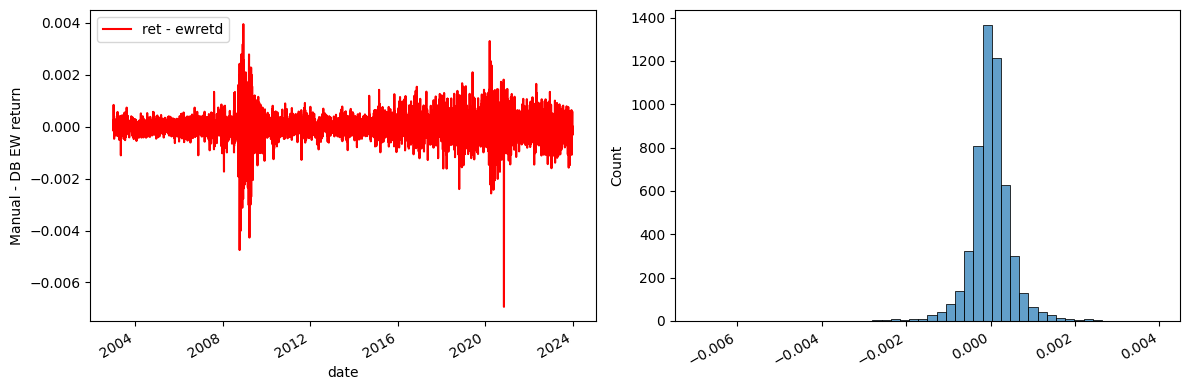

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=temp.index, y=temp.ret - temp.ewretd, ax=ax[0], label='ret - ewretd', color='red')
sns.histplot(temp.ret - temp.ewretd, ax=ax[1], bins=50, alpha=0.7, label='ret - ewretd')
ax[0].set_ylabel('Manual - DB EW return')
fig.autofmt_xdate()
plt.tight_layout(); plt.show()

In [60]:
temp = None
conn.close()

Finalizing and exporting data

In [64]:
# first converting to log returns (aggregate linearly over time, unlike simple returns)
df['ret'] = log1p(df.ret)

for col in ('vwretd', 'ewretd', 'sprtrn'):
    sp500[col] = log1p(sp500[col].astype(float))

In [67]:
%%time
# computing mean daily log return over a week (+ pulling other columns again)
sp500 = sp500.resample('W', on='caldt').apply({col: 'mean' for col in ('vwretd', 'ewretd', 'sprtrn')})

df = df.groupby('permno').resample('W', on='date').apply({
        'start': 'last', 'ending': 'last', 'ticker': 'last', 'ret': 'mean'
    })

CPU times: user 5min 4s, sys: 79.1 ms, total: 5min 4s
Wall time: 5min 4s


In [78]:
# converting mean daily log return to weekly simple return
sp500 = exp(sp500 * ANN_FACTOR) - 1
df['ret'] = exp(df.ret * ANN_FACTOR) - 1

In [82]:
df = df.reset_index().dropna(how='any')

In [83]:
with open('./data/stocks.pkl', 'wb') as f:
    pickle.dump(df, f)

with open('./data/market.pkl', 'wb') as f:
    pickle.dump(sp500, f)